<a href="https://colab.research.google.com/github/ap12798/Applied_Deep_Learning/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This Applied Deep Learning Project will determine the stock trend of Deere (stock abrev DE) for the beginning of 2021. The notebook will make use of the library yfinance to access Deere's beginning day stock price for the past 10 years. Stacked LSTM, dropout, adam optimizer

Notes:


*   Landed on batch size of 32, tried 16 and 128. 16 couldn't get to the same loss that 32 got to and 128 seemed like the predicted stock prices could not predict the day to day changes, but did fine in overall trend.
*   Found that 50 landed on the best loss tried 16 64 and 128
*   The lower loss usually came between 15 and 16 epochs, so landed on 16 epochs



Table of Contents

1.   Started with Stacked LSTM with 60 days of reference prices. Loss: .000438 and percent error 7.9%
2.   Experimented with same model, but 30 and 90 days of reference prices. instead of 60 days, surprisingly the 90 days performed better, so stuck with the 90 days for the rest of the models. 30 days loss .00059 and percent error 8.9% while 90 days loss .00049 and percent error 4.60%
3.   90 days Simple RNN loss .00024 and percent error 4.15%
4.   90 days Layered RNN loss .000737 and percenter error 5.17%
5.   90 days Bidirectional RNN performed the best out of all at loss .00034 and percent error 1.99



In [1]:
!pip install yfinance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import statistics as stat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers import Dropout

Training Set and Test set. Test set isn't used until later. Accessing data from yahoo library and setting training data last 10 years and test data to 2021 up until end of May

In [3]:
data_train = yf.download("DE", start="2010-01-01", end="2020-12-31") # defaults to one price per day
data_test = yf.download("DE", start="2021-01-01", end="2021-05-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**Looking at the pandas output complete from yahoo, will trim down to just open price**

In [4]:
data_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,54.740002,56.200001,54.340000,56.060001,43.838268,3974600
2010-01-05,56.189999,56.560001,55.599998,55.849998,43.674049,3007400
2010-01-06,55.570000,56.040001,55.220001,55.700001,43.556759,2854500
2010-01-07,55.380001,56.130001,55.169998,56.099998,43.869537,2694000
2010-01-08,55.779999,57.750000,55.299999,57.630001,45.065994,4165500


## Prepocessing data to just look at Openning stock price

In [5]:
train_set = data_train.iloc[:, 1:2].values # grabbing just the stock open price, iloc used to get right index for opening (creating a numpy array)
test_set = data_test.iloc[:, 1:2].values

## General look at the 2,768 market days before 2021

No handles with labels found to put in legend.


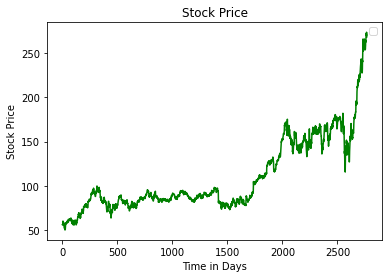

In [6]:
plt.plot(train_set, color = 'green')
plt.title('Stock Price')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [7]:
# normalizing the test data
sc = MinMaxScaler() # defaults to zero and one
train_set_scaled = sc.fit_transform(train_set) # applying fit transform method to sc

X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(60, 2768): # need to start at the 60th 
  X_train.append(train_set_scaled[i-60:i, 0]) # adding data to X_train (60 previous stock price before i'th day)
  y_train.append(train_set_scaled[i,0]) # adding data to y_train (time at t+1) - i because indexes start at zero
X_train = np.array(X_train) # convert list to numpy array
y_train = np.array(y_train) # convert list to numpy array

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # reshaping data and adding a dimension for the single indicator we are trying to predict

data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)

inputs = data_set_total[len(data_set_total) - len(data_test) - 60:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(60, 162): # 60 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

# Function to calculate the percent error
def percent_error(a, b) :
    result = int(((b - a) * 100) / a)
    return result

In [8]:
X_test.shape

(102, 60, 1)

**Preprocessing is done now, we have X_test in the format we need along with a small user defined function to calculate the average percent error.**

## Defined all hyperparameters so it was easy to change and compare

In [9]:
# hyperparameters
dropout = 0.2 # kept dropout pretty consistent throughout
neurons = 64 # tried 32 and 128 and couldn't get the same performance
epochs = 50 # tried 16 and 32 and 64 but 50 gave lowest loss value
batch_size = 32 # tried 16 and 128, 16 couldn't get the same loss value and 128 could track in performance as well as 32
optimizer = 'adam' # best optimizer for RNNs, tried RMS prop, but better results with Adam
loss = 'mean_squared_error' # used to measure how well you are at predicted continious variable like stock price

### **1. Stacked LSTM**

 

*   #### Model seems to perform well and catches most of the stock price changes.
*   #### Also the average % error is relatively lower than the other models


In [10]:
model_stacked_LSTM = Sequential()
model_stacked_LSTM.add(LSTM(neurons, return_sequences = True, input_shape = (X_train.shape[1], 1))) # first layer
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(LSTM(neurons, return_sequences = True))
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(LSTM(neurons, return_sequences = True))
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(LSTM(neurons))
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(Dense(1))

In [11]:
model_stacked_LSTM.compile(optimizer = optimizer, loss = loss)

In [12]:
model_stacked_LSTM.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
85/85 [==============================] - 30s 103ms/step - loss: 0.0184
Epoch 2/50
85/85 [==============================] - 8s 100ms/step - loss: 0.0018
Epoch 3/50
85/85 [==============================] - 8s 100ms/step - loss: 0.0016
Epoch 4/50
85/85 [==============================] - 8s 99ms/step - loss: 0.0023
Epoch 5/50
85/85 [==============================] - 8s 99ms/step - loss: 0.0014
Epoch 6/50
85/85 [==============================] - 9s 100ms/step - loss: 0.0017
Epoch 7/50
85/85 [==============================] - 9s 100ms/step - loss: 0.0014
Epoch 8/50
85/85 [==============================] - 9s 101ms/step - loss: 0.0018
Epoch 9/50
85/85 [==============================] - 8s 99ms/step - loss: 0.0011
Epoch 10/50
85/85 [==============================] - 9s 100ms/step - loss: 0.0012
Epoch 11/50
85/85 [==============================] - 9s 105ms/step - loss: 9.6333e-04
Epoch 12/50
85/85 [==============================] - 9s 105ms/step - loss: 0.0012
Epoch 13/50
85/85 [====

In [13]:
predicted_stock_price_stacked_LSTM = model_stacked_LSTM.predict(X_test)
predicted_stock_price_stacked_LSTM = sc.inverse_transform(predicted_stock_price_stacked_LSTM) # going back from normalizing

Chart below shows the actual stock price in green and predicted stock price in blue. No training data is displayed here.

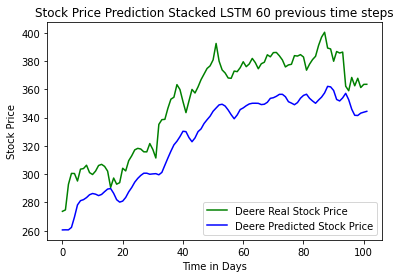

In [14]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_stacked_LSTM, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction Stacked LSTM 60 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Model tracks well over time but doesn't do a great job of finding all peaks. Percent error is better than the 30 and 90 day experiments

In [15]:
print(percent_error(predicted_stock_price_stacked_LSTM[20],test_set[20]), "%")

8 %


In [16]:
print(percent_error(predicted_stock_price_stacked_LSTM[50],test_set[50]), "%")

10 %


In [17]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_stacked_LSTM, test_set)]
(sum(c)/len(c))[0]

7.915721517798314

## **2. Below are simulations with different time steps, all stacked LSTMs**
Below is the summary of the loss and percent error





* 30 time steps loss: .00056840
* 30 time steps percent error: 2.9%
* 60 time steps loss: .00063653
* 60 time steps percent error: 2.8%
* 90 time steps loss: .00069412
* 90 time steps percent error: 6.6%

### 30 day window
Need to make a small modification to the data preprocessing to look at the previous 30 days.

In [18]:
X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(30, 2768): #len(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-30:i, 0])
  y_train.append(train_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)

inputs = data_set_total[len(data_set_total) - len(data_test) - 30:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(30, 132): # 30 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-30:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

In [19]:
model_stacked_LSTM_30 = Sequential()
model_stacked_LSTM_30.add(LSTM(neurons, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(LSTM(neurons, return_sequences = True))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(LSTM(neurons, return_sequences = True))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(LSTM(neurons))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(Dense(1))

In [20]:
model_stacked_LSTM_30.compile(optimizer = optimizer, loss = loss)

In [21]:
model_stacked_LSTM_30.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
86/86 [==============================] - 10s 52ms/step - loss: 0.0155
Epoch 2/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0019
Epoch 3/50
86/86 [==============================] - 5s 52ms/step - loss: 0.0017
Epoch 4/50
86/86 [==============================] - 5s 54ms/step - loss: 0.0017
Epoch 5/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0014
Epoch 6/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0015
Epoch 7/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0012
Epoch 8/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0012
Epoch 9/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0013
Epoch 10/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0011
Epoch 11/50
86/86 [==============================] - 5s 53ms/step - loss: 0.0011
Epoch 12/50
86/86 [==============================] - 4s 52ms/step - loss: 0.0011
Epoch 13/50
86/86 [=================

In [22]:
predicted_stock_price_stacked_LSTM_30 = model_stacked_LSTM_30.predict(X_test)
predicted_stock_price_stacked_LSTM_30 = sc.inverse_transform(predicted_stock_price_stacked_LSTM_30) # going back from normalizing

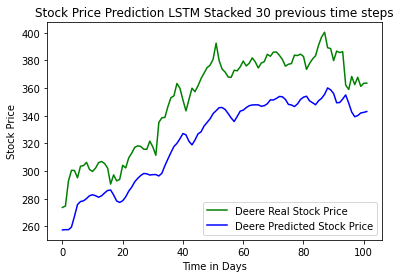

In [23]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_stacked_LSTM_30, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction LSTM Stacked 30 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#### It seems like this model is slightly slower to respond to changes in stock price, still good percent error but doesn't track as well as the 60 day model

In [24]:
print(abs(percent_error(predicted_stock_price_stacked_LSTM_30[20],test_set[20])), "%")

9 %


In [25]:
print(abs(percent_error(predicted_stock_price_stacked_LSTM_30[50],test_set[50])), "%")

11 %


In [26]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_stacked_LSTM_30,test_set)]
(sum(c)/len(c))[0]

8.856506383948885

### 90 day window
Need to make a small modification to the data preprocessing to look at the previous 90 days.

In [27]:
X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(90, 2768): #len(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-90:i, 0])
  y_train.append(train_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # reshaping data

data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)


inputs = data_set_total[len(data_set_total) - len(data_test) - 90:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(90, 192): # 90 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-90:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

In [28]:
model_stacked_LSTM_90 = Sequential()
model_stacked_LSTM_90.add(LSTM(neurons, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(LSTM(neurons, return_sequences = True))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(LSTM(neurons, return_sequences = True))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(LSTM(neurons))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(Dense(1))

In [29]:
model_stacked_LSTM_90.compile(optimizer = optimizer, loss = loss)

In [30]:
model_stacked_LSTM_90.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
84/84 [==============================] - 18s 145ms/step - loss: 0.0112
Epoch 2/50
84/84 [==============================] - 12s 147ms/step - loss: 0.0021
Epoch 3/50
84/84 [==============================] - 12s 145ms/step - loss: 0.0017
Epoch 4/50
84/84 [==============================] - 12s 145ms/step - loss: 0.0019
Epoch 5/50
84/84 [==============================] - 12s 148ms/step - loss: 0.0013
Epoch 6/50
84/84 [==============================] - 12s 146ms/step - loss: 0.0014
Epoch 7/50
84/84 [==============================] - 12s 146ms/step - loss: 0.0013
Epoch 8/50
84/84 [==============================] - 12s 146ms/step - loss: 0.0012
Epoch 9/50
84/84 [==============================] - 12s 147ms/step - loss: 0.0012
Epoch 10/50
84/84 [==============================] - 12s 147ms/step - loss: 0.0011
Epoch 11/50
84/84 [==============================] - 12s 145ms/step - loss: 0.0010
Epoch 12/50
84/84 [==============================] - 12s 147ms/step - loss: 0.0011
Epoch 13/50
8

In [31]:
predicted_stock_price_stacked_LSTM_90 = model_stacked_LSTM_90.predict(X_test)
predicted_stock_price_stacked_LSTM_90 = sc.inverse_transform(predicted_stock_price_stacked_LSTM_90) # going back from normalizing

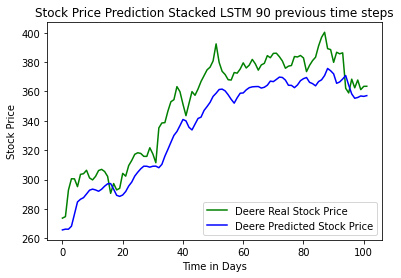

In [32]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_stacked_LSTM_90, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction Stacked LSTM 90 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [33]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_stacked_LSTM_90, test_set)]
(sum(c)/len(c))[0]

4.618213977661861

### Note about 90 day

## **3. Below is running a simple RNN for comparision to the stacked LSTM** 

In [34]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(units = neurons, input_shape = (X_train.shape[1], 1)))
model_RNN.add(Dropout(dropout))
model_RNN.add(Dense(1))

In [35]:
model_RNN.compile(optimizer = optimizer, loss = loss)

In [36]:
model_RNN.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
84/84 [==============================] - 7s 12ms/step - loss: 0.0279
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0021
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 7/50
84/84 [==============================] - 1s 11ms/step - loss: 9.3525e-04
Epoch 8/50
84/84 [==============================] - 1s 11ms/step - loss: 8.8956e-04
Epoch 9/50
84/84 [==============================] - 1s 11ms/step - loss: 8.4933e-04
Epoch 10/50
84/84 [==============================] - 1s 11ms/step - loss: 7.8096e-04
Epoch 11/50
84/84 [==============================] - 1s 11ms/step - loss: 7.2308e-04
Epoch 12/50
84/84 [==============================] - 1s 12ms/step - loss: 7.6390e-04
Epoch 13/50
8

In [37]:
predicted_stock_price_RNN = model_RNN.predict(X_test)
predicted_stock_price_RNN = sc.inverse_transform(predicted_stock_price_RNN)

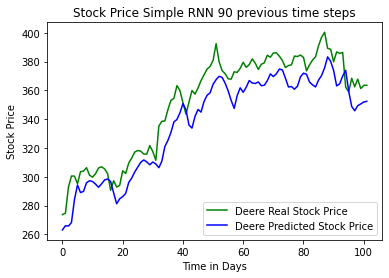

In [52]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_RNN, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Simple RNN 90 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Simple RNN doesn't perform very well based on the predicted stock price above. Relatively high percent error when comparing 20th and 50th day stock price and average error

In [39]:
print(percent_error(predicted_stock_price_RNN[20],test_set[20]), "%")

6 %


In [40]:
print(percent_error(predicted_stock_price_RNN[50],test_set[50]), "%")

4 %


In [41]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_RNN,test_set)]
(sum(c)/len(c))[0]

4.153068520682159

## **4. Now shifting to a layered RNN**

In [42]:
model_rnn_layer = Sequential()
model_rnn_layer.add(SimpleRNN(neurons, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model_rnn_layer.add(Dropout(dropout))
model_rnn_layer.add(SimpleRNN(neurons, return_sequences=True))
model_rnn_layer.add(Dropout(dropout))
model_rnn_layer.add(SimpleRNN(neurons))
model_rnn_layer.add(Dropout(dropout))
model_rnn_layer.add(Dense(1))

In [43]:
model_rnn_layer.compile(optimizer = optimizer, loss = loss)

In [44]:
model_rnn_layer.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
84/84 [==============================] - 7s 45ms/step - loss: 0.3993
Epoch 2/50
84/84 [==============================] - 4s 43ms/step - loss: 0.0596
Epoch 3/50
84/84 [==============================] - 4s 43ms/step - loss: 0.0246
Epoch 4/50
84/84 [==============================] - 4s 42ms/step - loss: 0.0153
Epoch 5/50
84/84 [==============================] - 4s 43ms/step - loss: 0.0122
Epoch 6/50
84/84 [==============================] - 4s 44ms/step - loss: 0.0085
Epoch 7/50
84/84 [==============================] - 4s 42ms/step - loss: 0.0066
Epoch 8/50
84/84 [==============================] - 4s 43ms/step - loss: 0.0055
Epoch 9/50
84/84 [==============================] - 4s 43ms/step - loss: 0.0050
Epoch 10/50
84/84 [==============================] - 4s 42ms/step - loss: 0.0042
Epoch 11/50
84/84 [==============================] - 4s 43ms/step - loss: 0.0036
Epoch 12/50
84/84 [==============================] - 4s 43ms/step - loss: 0.0033
Epoch 13/50
84/84 [==================

In [45]:
predicted_stock_price_rnn_layer = model_rnn_layer.predict(X_test)
predicted_stock_price_rnn_layer = sc.inverse_transform(predicted_stock_price_rnn_layer) # going back from normalizing

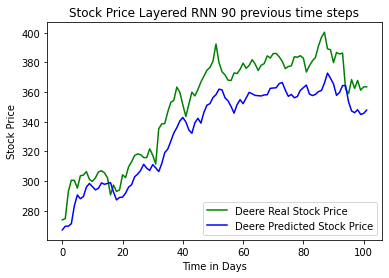

In [53]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_rnn_layer, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Layered RNN 90 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Model is even worse than previous models, percent error is greater and you can tell by graph that predicted 'blue' is shifted down consistently

In [47]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_rnn_layer,test_set)]
(sum(c)/len(c))[0]

5.1726553980897005

##  **5. Bidirectional LSTM**

In [48]:
model_bidirectional_LSTM = Sequential()
model_bidirectional_LSTM.add (Bidirectional(LSTM(neurons, input_shape = (X_train.shape[1], 1))))
model_bidirectional_LSTM.add(Dropout(dropout))
model_bidirectional_LSTM.add(Dense(1))
model_bidirectional_LSTM.compile(optimizer = optimizer, loss = loss)
model_bidirectional_LSTM.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
84/84 [==============================] - 19s 45ms/step - loss: 0.0177
Epoch 2/50
84/84 [==============================] - 4s 46ms/step - loss: 0.0015
Epoch 3/50
84/84 [==============================] - 4s 45ms/step - loss: 0.0012
Epoch 4/50
84/84 [==============================] - 4s 46ms/step - loss: 8.2026e-04
Epoch 5/50
84/84 [==============================] - 4s 47ms/step - loss: 8.5573e-04
Epoch 6/50
84/84 [==============================] - 4s 46ms/step - loss: 7.5749e-04
Epoch 7/50
84/84 [==============================] - 4s 46ms/step - loss: 8.2453e-04
Epoch 8/50
84/84 [==============================] - 4s 45ms/step - loss: 7.5061e-04
Epoch 9/50
84/84 [==============================] - 4s 45ms/step - loss: 6.5883e-04
Epoch 10/50
84/84 [==============================] - 4s 46ms/step - loss: 6.2723e-04
Epoch 11/50
84/84 [==============================] - 4s 46ms/step - loss: 6.0920e-04
Epoch 12/50
84/84 [==============================] - 4s 46ms/step - loss: 5.7081e-04


In [49]:
predicted_stock_price_birectional_LSTM = model_bidirectional_LSTM.predict(X_test)
predicted_stock_price_birectional_LSTM = sc.inverse_transform(predicted_stock_price_birectional_LSTM) # going back from normalizing

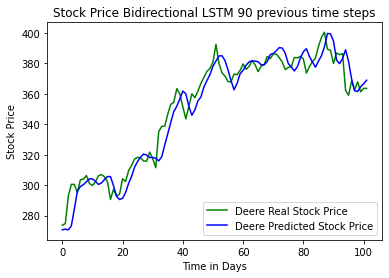

In [54]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_birectional_LSTM, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Bidirectional LSTM 90 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [51]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_birectional_LSTM,test_set)]
(sum(c)/len(c))[0]

1.9858572218695678